/var/folders/s6/4wdnb9rx1cl3r28sklncyvs00000gs/T/ipykernel_11261/66923191.py:12: RuntimeWarning: divide by zero encountered in log10
  HyMAG=np.array([np.log10(np.linalg.norm(ii)) for ii in Hy])


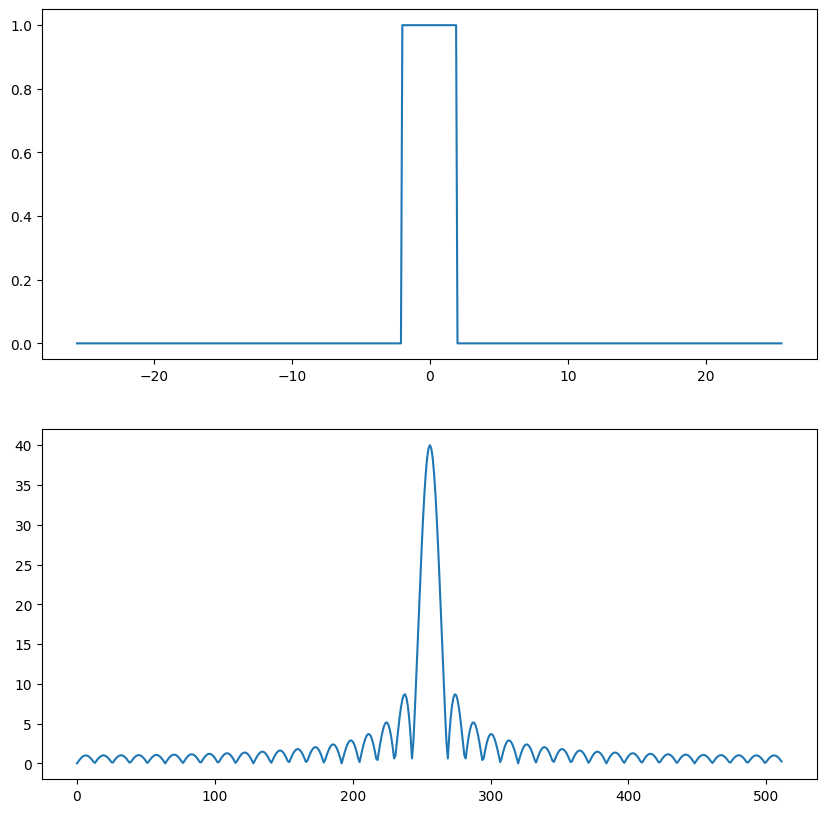

In [66]:
#plot 1D Sky View function and its fft (which is the interference pattern)
#
# 
import numpy as np
from matplotlib import pyplot as plt
x=np.arange(-25.6,25.6,0.1,dtype=float)
y=np.zeros(512)+1e-15
y[np.abs(x)<2.0]=1.0
fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].plot(x,y)
Hy=np.fft.fftshift(np.fft.fft(np.fft.ifftshift(y)))
HyMAG=np.array([np.log10(np.linalg.norm(ii)) for ii in Hy])
HyMAG=np.array([np.linalg.norm(ii) for ii in Hy])
#HyMAG=np.array([np.linalg.norm(ii) for ii in Hy])
ax[1].plot(HyMAG)



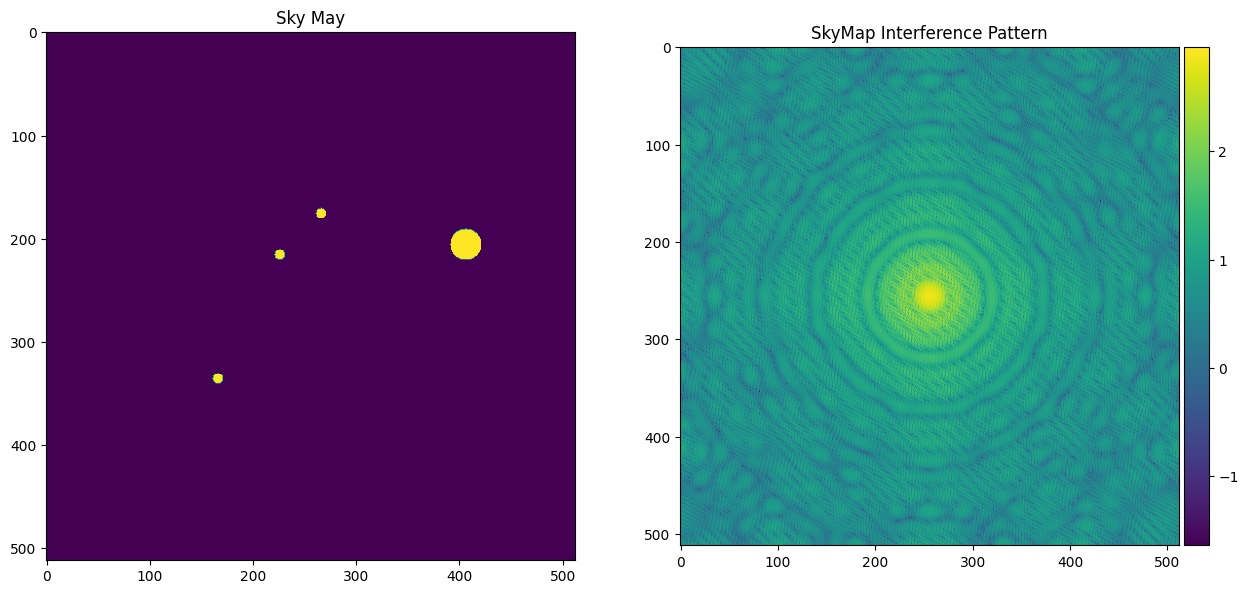

In [67]:
# Create Sky view and show FFT of sky.

from mpl_toolkits.axes_grid1 import make_axes_locatable
def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

stepSize=0.1

dot=lambda mx,my,r,s,o : np.array([[0. if ((x+o[0])**2+(y+o[1])**2)>(r*r) else 1. for x in np.arange(-mx,mx,s)] for y in np.arange(-my,my,s)])

#SKYMAP DOTS
yy=dot(25.6,25.6,1.5,stepSize,(-15.,5.))  + \
   dot(25.6,25.6,0.5,stepSize,(3.,4.)) +  \
   dot(25.6,25.6,0.5,stepSize,(-1.,8.))+  \
   dot(25.6,25.6,0.5,stepSize,(9.,-8.))
Hyy=calculate_2dft(yy)
HyyMAG=np.array([[np.log10(np.linalg.norm(ii)) for ii in jj] for jj in Hyy])

fig,ax=plt.subplots(1,2,figsize=(15,15))
#ax[0].imshow(yy)
im=[ax[jjj].imshow(data) for jjj,data in enumerate([yy,HyyMAG])]
[ax[jjj].set_title(data) for jjj,data in enumerate(["Sky May","SkyMap Interference Pattern"])]

# plt.colorbar(im[1],ax=ax[1])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im[1], cax=cax, orientation='vertical')


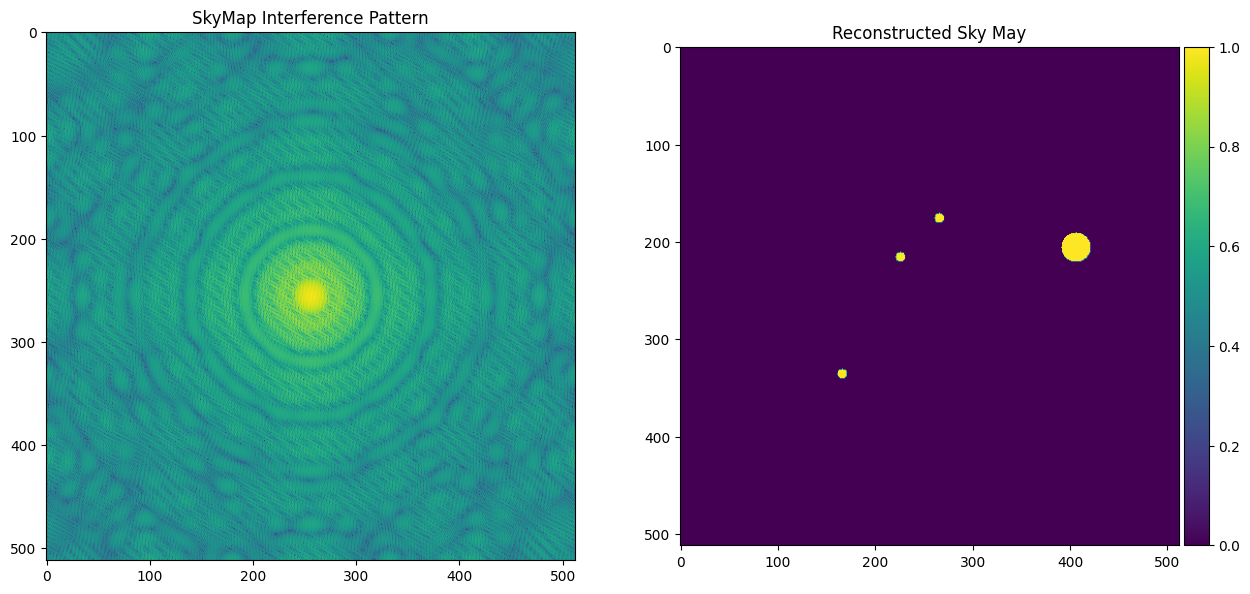

In [68]:
#INVERT the interference pattern back to original

def calculate_2dift(input):
    ft = np.fft.fftshift(input)
    ft = np.fft.ifft2(ft)
    return np.fft.ifftshift(ft)

BackHyyMAG=calculate_2dift(Hyy)
fig,ax=plt.subplots(1,2,figsize=(15,15))
#ax[0].imshow(yy)
im=[ax[jjj].imshow(data) for jjj,data in enumerate([HyyMAG,BackHyyMAG.real])]
[ax[jjj].set_title(data) for jjj,data in enumerate(["SkyMap Interference Pattern","Reconstructed Sky May"])]

# plt.colorbar(im[1],ax=ax[1])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im[1], cax=cax, orientation='vertical')



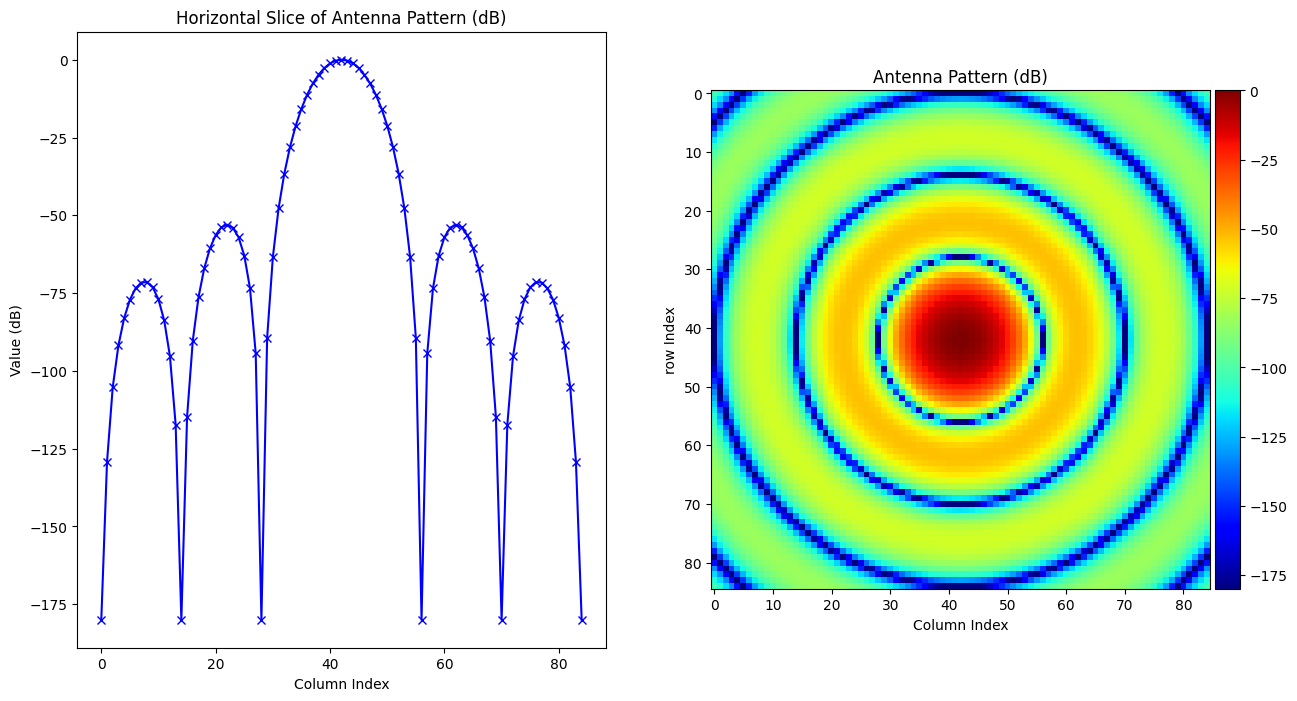

In [166]:
def generate_sinc_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            distance = np.sqrt(x**2 + y**2)
            kernel[i, j] = (np.sinc(distance / sigma)**2)**2+1e-9
    return kernel

# Example usage
kernel_size = 85
sigma = 14.0
antenna_kernel = generate_sinc_kernel(kernel_size, sigma)


# Choose the row index for the horizontal slice
row_index = antenna_kernel.shape[0] // 2

# Get the horizontal slice from the array
horizontal_slice = antenna_kernel[row_index, :]

fig,ax=plt.subplots(1,2,figsize=(15,8))
imSlice=ax[0].plot(20*np.log10(horizontal_slice),'bx-')
ax[0].set_xlabel('Column Index')
ax[0].set_ylabel('Value (dB)')
ax[0].set_title('Horizontal Slice of Antenna Pattern (dB)')
imKernel=ax[1].imshow(20*np.log10(antenna_kernel), cmap='jet')
ax[1].set_xlabel('Column Index')
ax[1].set_ylabel('row Index')
ax[1].set_title('Antenna Pattern (dB)')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imKernel, cax=cax, orientation='vertical')



Temperature: 300 K and Bandwidth: 1000000.0 Hz
Noise floor: -143.83 dB


/var/folders/s6/4wdnb9rx1cl3r28sklncyvs00000gs/T/ipykernel_11261/1791361262.py:72: RuntimeWarning: invalid value encountered in log10
  im[1][0]=ax[1][0].imshow(20*np.log10(sampleOut.real),cmap='jet')


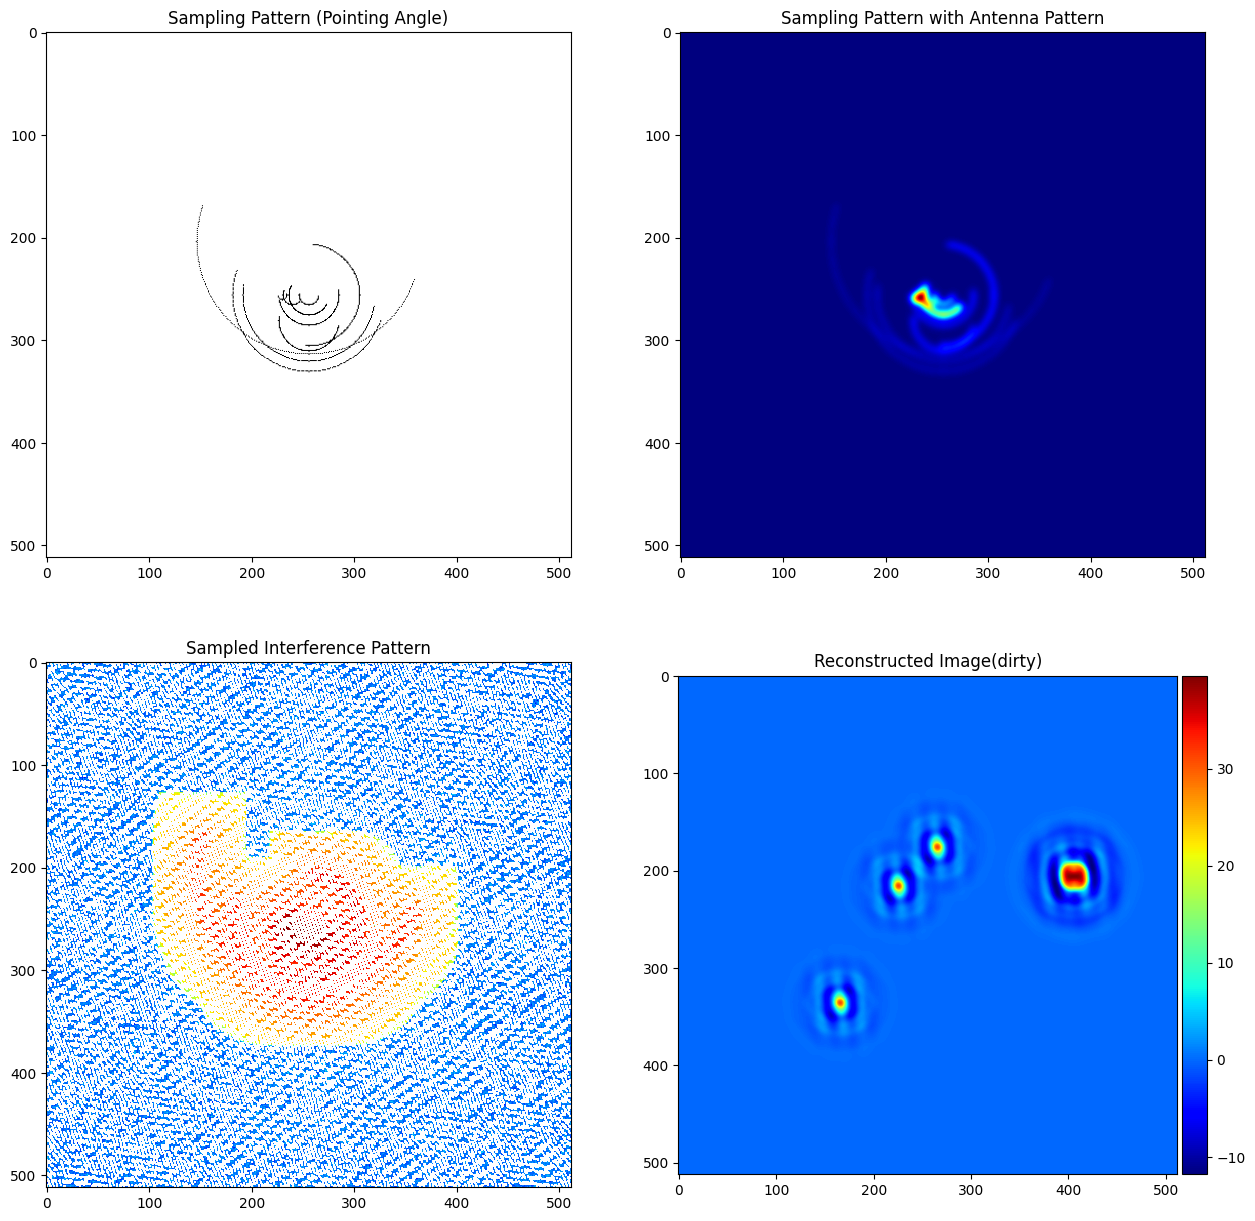

In [178]:

#implement a sampling function which samples part of the interference pattern.
#
# ifft the sampled sky view gives the dirty image of the sky 
#
rotMat = lambda rot:np.matrix([[np.cos(rot/57.295779513),-np.sin(rot/57.295779513)],[np.sin(rot/57.295779513),np.cos(rot/57.295779513)]])
rotate = lambda rot,xy:tuple((np.int16(rotMat(rot)*np.matrix(xy).transpose())).transpose().tolist()[0])
r=[(10,60,0.5,0.47),(30,80,0.55,0.5),(110,70,0.4,0.5), \
   (5,110,0.5,0.45),(20,60,0.5,0.5),(50,175,0.5,0.5),  \
     (65,80,0.5,0.5),(20,60,0.5,0.5),(75,70,0.5,0.5),   \
     (20,60,0.5,0.5),(50,175,0.5,0.5),(10,80,0.5,0.5),  \
     (20,60,0.5,0.5),(-30,280,0.5,0.5)]
# 
t=180
sample=np.zeros(Hyy.shape)+1e-15
uvPoints=np.zeros(Hyy.shape)+1e-15

#################  ADD NOISE TO THE SAMPLED POINTS
# Generate log-normal distributed noise

# calculate the mean and standard deviation of the noise floor using bolzmann's equation and the system temperature
# T = 290 K
# B = 1 Hz
# k = 1.38064852e-23 J/K
# noise_floor = k * T / B
T,B,k=300,1e6,1.38064852e-23
noise_floor = k * T * B
print("Temperature: {} K and Bandwidth: {} Hz".format(T,B))
print("Noise floor: {:.2f} dB".format(10*np.log10(noise_floor)))

Tsys = 3 #system noise in dB 

std = 3 # Standard deviation of the distribution in dB

noiseArray = np.power(10,np.random.normal(10*np.log10(noise_floor)+Tsys, 10, Hyy.shape)/10 )
sample = np.power(10,np.random.normal(10*np.log10(noise_floor)+Tsys, 10, Hyy.shape)/10 )

#First we create the skymap sampling pattern
for ll in r:
    for lll in [rotate(ll[1]-t,(ll[0],0)) for t in range(t)]:
        x,y=(int(lll[0]+len(Hyy[0])*ll[2]),int(lll[1]+len(Hyy)*ll[3]))
        uvPoints[x,y]=1.0
            # Calculate the starting indices of the kernel
        start_x = x - antenna_kernel.shape[0] // 2
        start_y = y - antenna_kernel.shape[1] // 2
        
        # Iterate over each element in the kernel
        for i in range(antenna_kernel.shape[0]):
            for j in range(antenna_kernel.shape[1]):
                # Check if the kernel element is within the buffer boundaries
                if 0 <= start_x + i < sample.shape[0] and 0 <= start_y + j < sample.shape[1]:
                    # Add the value of the kernel to the corresponding element in BUFF
                    sample[start_x + i, start_y + j] += antenna_kernel[i, j]

        #sample[int(lll[0]+len(Hyy[0])*ll[2])][int(lll[1]+len(Hyy)*ll[3])]=1.0  #Hyy[lll[0]+len(Hyy[0])//2][lll[1]+len(Hyy)//2]

########
# Perform the sampling of the sky map using the skymap sampling pattern
########
sampleOut=sample*Hyy+noiseArray
########
# Perform the inverse fourier transform of the sampled sky map
########
BackHyyMAG=calculate_2dift(sampleOut)

########
# Plot the results
########
fig,ax=plt.subplots(2,2,figsize=(15,15))
im=[[1,2],[0,0]]
im[0][0]=ax[0][0].imshow(uvPoints,cmap='binary')
im[0][1]=ax[0][1].imshow(sample, cmap='jet')
im[1][0]=ax[1][0].imshow(20*np.log10(sampleOut.real),cmap='jet')
im[1][1]=ax[1][1].imshow(BackHyyMAG.real,cmap='jet')
[ax[1][jjj].set_title(data) for jjj,data in enumerate(["Sampled Interference Pattern","Reconstructed Image(dirty)"])]
[ax[0][jjj].set_title(data) for jjj,data in enumerate(["Sampling Pattern (Pointing Angle)","Sampling Pattern with Antenna Pattern"])]
# #ax[0].imshow(yy)
# im=[ax[jjj].imshow(data) for jjj,data in enumerate([sample,BackHyyMAG.real])]
# plt.colorbar(im[1],ax=ax[1])
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im[1][1], cax=cax, orientation='vertical')


In [ ]:
radiusOfSun=6.96342e5*1000  #m
lightYear=9.4607e15 #m
 